# YOLOv3 Architecture

In [2]:
"""
Implementation of YOLOv3 architecture
"""
 
import torch
import torch.nn as nn
 
""" 
Information about architecture config:
Tuple is structured by (filters, kernel_size, stride) 
Every conv is a same convolution. 
List is structured by "B" indicating a residual block followed by the number of repeats
"S" is for scale prediction block and computing the yolo loss
"U" is for upsampling the feature map and concatenating with a previous layer
"""
config = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],  # To this point is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]
 
 
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bn_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=not bn_act, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.leaky = nn.LeakyReLU(0.1)
        self.use_bn_act = bn_act
 
    def forward(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)
 
 
class ResidualBlock(nn.Module):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = nn.ModuleList()
        for repeat in range(num_repeats):
            self.layers += [
                nn.Sequential(
                    CNNBlock(channels, channels // 2, kernel_size=1),
                    CNNBlock(channels // 2, channels, kernel_size=3, padding=1),
                )
            ]
 
        self.use_residual = use_residual
        self.num_repeats = num_repeats
 
    def forward(self, x):
        for layer in self.layers:
            if self.use_residual:
                x = x + layer(x)
            else:
                x = layer(x)
 
        return x
 
 
class ScalePrediction(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.pred = nn.Sequential(
            CNNBlock(in_channels, 2 * in_channels, kernel_size=3, padding=1),
            CNNBlock(
                2 * in_channels, 5 * 3, bn_act=False, kernel_size=1
            ),
        )
 
    def forward(self, x):
        return (
            self.pred(x)
            .reshape(x.shape[0], 3, 5, x.shape[2], x.shape[3])
            .permute(0, 1, 3, 4, 2)
        )

#This module applies the math opperations from the YOLO paper to retrieve the true coordinates and with and height of the bboxes instead of doing this at a later stage.
class MathOperations(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()
        self.anchors = (torch.tensor(CONFIG.ANCHORS) * torch.tensor(CONFIG.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)).to(CONFIG.DEVICE)
 
    """

    x is in the shape N x 3 x S x S x 5
    we want the last dimension to be in this order: [x, y, w, h, obj]
    In the forward we'll apply the mathematical operations described in both YOLO 9000 and YOLO V3 papers

    bx = sigma(tx) + cx
    by = sigma(ty) + cy
    bw = pw * exp(tw)
    bh = ph * exp(th)

    cx/cy = location of upper left corner of cell
    pw/ph = prior size of the anchor box
    t = vector before operation
    b = vector after operation

    """
    def forward(self, x, scale):
        # return  torch.cat([self.sigmoid(predictions[..., 1:3]), torch.exp(predictions[..., 3:5]) * anchors], dim=-1)
        return  torch.cat([self.sigmoid(x[..., 0:2]), torch.exp(x[..., 2:4]) * self.anchors[scale].reshape(1, 3, 1, 1, 2), self.sigmoid(x[..., 4:5])], dim=-1)
# N = 8
# S = 56
# anchors = torch.tensor(CONFIG.ANCHORS[0])
# print(anchors)
# x_test = torch.tensor([10, -20, -5, 1, 2000])
# x_test = x_test.repeat(N, 3, S, S, 1)
# print(x_test[0, 0, 0, 0])

# layer_test = MathOperations(0, anchors)
# output = layer_test(x_test)
# print(output[0,1,0,0])
        
        

 
 
class YOLOv3(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()
 
    def forward(self, x):
        outputs = []  # for each scale
        route_connections = []
        MathOperationsLayer = MathOperations()
        for layer in self.layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(MathOperationsLayer(layer(x),len(outputs)))
                continue
 
            x = layer(x)
 
            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)
 
            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()
 
        return outputs
 
    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels
 
        for module in config:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNNBlock(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                in_channels = out_channels
 
            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(ResidualBlock(in_channels, num_repeats=num_repeats,))
 
            elif isinstance(module, str):
                if module == "S":
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels, in_channels // 2, kernel_size=1),
                        ScalePrediction(in_channels // 2),
                    ]
                    in_channels = in_channels // 2
 
                elif module == "U":
                    layers.append(nn.Upsample(scale_factor=2),)
                    in_channels = in_channels * 3
 
        return layers

# Config

In [4]:
import albumentations as A
import cv2
import torch
 
from albumentations.pytorch import ToTensorV2

class Config:

  def __init__(self):
    self.DATA_PATH = '../wider_face/'
    self.INDEX_PATH_TRAIN = self.DATA_PATH + 'annotation/wider_face_train_bbx_gt.txt'
    self.INDEX_PATH_VAL = self.DATA_PATH + 'annotation/wider_face_val_bbx_gt.txt'
    self.IMAGE_STORE_PATH_TRAIN = self.DATA_PATH + 'train/'
    self.IMAGE_STORE_PATH_VAL = self.DATA_PATH + 'validation/'
    self.ANCHORS = [
      [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
      [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
      [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
    ]  # Note these have been rescaled to be between [0, 1]
  

    #TODO replace these by what we use
    self.DATASET = '/PASCAL_VOC'
    self.IMG_DIR = '/PASCAL_VOC/images/'
    self.LABEL_DIR = '/PASCAL_VOC/labels/'
    self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    # UTILS.seed_everything()  # If you want deterministic behavior
    self.NUM_WORKERS = 0 #4 causes errors on windows to have more than 0
    self.BATCH_SIZE = 12
    self.IMAGE_SIZE = 416
    self.LEARNING_RATE = 1e-4
    self.WEIGHT_DECAY = 0 #1e-4 staat uit nu om te overfitten, kan aan tijdens echte trainen
    self.NUM_EPOCHS = 100
    self.CONF_THRESHOLD = 0.7#0.05
    self.MAP_IOU_THRESH = 0.25#0.5
    self.NMS_IOU_THRESH = 0.25#0.45
    self.S = [self.IMAGE_SIZE // 32, self.IMAGE_SIZE // 16, self.IMAGE_SIZE // 8]
    self.PIN_MEMORY = True
    self.LOAD_MODEL = False
    self.SAVE_MODEL = False
    self.CHECKPOINT_FILE = "..\checkpoint.pth.tar"
    
    self.ANCHORS = [
        [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
        [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
        [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
    ]  # Note these have been rescaled to be between [0, 1]
    
    self.scale = 1.1
    self.train_transforms = A.Compose(
        [
            A.LongestMaxSize(max_size=int(self.IMAGE_SIZE * self.scale)),
            A.PadIfNeeded(
                min_height=int(self.IMAGE_SIZE * self.scale),
                min_width=int(self.IMAGE_SIZE * self.scale),
                border_mode=cv2.BORDER_CONSTANT,
            ),
            A.RandomCrop(width=self.IMAGE_SIZE, height=self.IMAGE_SIZE),
            A.ColorJitter(brightness=0.6, contrast=0.6, saturation=0.6, hue=0.6, p=0.4),
            A.HorizontalFlip(p=0.5),
            A.Blur(p=0.1),
            A.CLAHE(p=0.1),
            A.Posterize(p=0.1),
            A.ToGray(p=0.1),
            A.ChannelShuffle(p=0.05),
            A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(format="coco", min_visibility=0.4, label_fields=[],),
    )

    self.test_transforms = A.Compose(
        [
            A.LongestMaxSize(max_size=self.IMAGE_SIZE),
            A.PadIfNeeded(
                min_height=self.IMAGE_SIZE, min_width=self.IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
            ),
            A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
            ToTensorV2(),
        ],
        bbox_params=A.BboxParams(format="coco", min_visibility=0.4, label_fields=[]),
    )

CONFIG = Config()

# Utils

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import random
import torch
import torchvision
 
from collections import Counter
from torch.utils.data import DataLoader
from tqdm import TqdmTypeError
from torchvision.ops import nms, box_iou, box_convert

class Utils():
 
  def iou_width_height(self, boxes1, boxes2):
      """
      Parameters:
          boxes1 (tensor): width and height of the first bounding boxes
          boxes2 (tensor): width and height of the second bounding boxes
      Returns:
          tensor: Intersection over union of the corresponding boxes
      """
      intersection = torch.min(boxes1[..., 0], boxes2[..., 0]) * torch.min(
          boxes1[..., 1], boxes2[..., 1]
      )
      union = (
          boxes1[..., 0] * boxes1[..., 1] + boxes2[..., 0] * boxes2[..., 1] - intersection
      )
      return intersection / union
  
  
  def intersection_over_union(self, boxes_preds, boxes_labels, box_format="midpoint"):
      """
      Video explanation of this function:
      https://youtu.be/XXYG5ZWtjj0
      This function calculates intersection over union (iou) given pred boxes
      and target boxes.
      Parameters:
          boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
          boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
          box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
      Returns:
          tensor: Intersection over union for all examples
      """
      if box_format == "midpoint":
          box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
          box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
          box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
          box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
          box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
          box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
          box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
          box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
  
      if box_format == "corners":
          box1_x1 = boxes_preds[..., 0:1]
          box1_y1 = boxes_preds[..., 1:2]
          box1_x2 = boxes_preds[..., 2:3]
          box1_y2 = boxes_preds[..., 3:4]
          box2_x1 = boxes_labels[..., 0:1]
          box2_y1 = boxes_labels[..., 1:2]
          box2_x2 = boxes_labels[..., 2:3]
          box2_y2 = boxes_labels[..., 3:4]
  
      x1 = torch.max(box1_x1, box2_x1)
      y1 = torch.max(box1_y1, box2_y1)
      x2 = torch.min(box1_x2, box2_x2)
      y2 = torch.min(box1_y2, box2_y2)
  
      intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
      box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
      box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
  
      return intersection / (box1_area + box2_area - intersection + 1e-6)
  
  
  def non_max_suppression(self, bboxes, iou_threshold, threshold, box_format="corners"):
      """
      Video explanation of this function:
      https://youtu.be/YDkjWEN8jNA
      Does Non Max Suppression given bboxes
      Parameters:
          bboxes (list): list of lists containing all bboxes with each bboxes
          specified as [x1, y1, x2, y2, obj_socre]
          iou_threshold (float): threshold where predicted bboxes is correct
          threshold (float): threshold to remove predicted bboxes (independent of IoU)
          box_format (str): "midpoint" or "corners" used to specify bboxes
      Returns:
          list: bboxes after performing NMS given a specific IoU threshold
      """
      assert type(bboxes) == list
  
      bboxes = [box for box in bboxes if box[4] > threshold]
      
      # bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
      # bboxes_after_nms = []
  
      # while bboxes:
      #     chosen_box = bboxes.pop(0)
      #     bboxes = [
      #         box
      #         for box in bboxes
      #         if box[0] != chosen_box[0]
      #         or self.intersection_over_union(
      #             torch.tensor(chosen_box[2:]),
      #             torch.tensor(box[2:]),
      #             box_format=box_format
      #         )
      #         < iou_threshold
      #     ]
  
      #     bboxes_after_nms.append(chosen_box)
      # return bboxes_after_nms
      if len(bboxes) > 0:
          boxes = box_convert(torch.tensor([box[:4] for box in bboxes]).to(CONFIG.DEVICE),'xywh', 'xyxy')
          scores = torch.tensor([box[4] for box in bboxes]).to(CONFIG.DEVICE)

          return [bboxes[i] for i in nms(boxes, scores, iou_threshold).tolist()]
      else:
          return bboxes


  def mean_average_precision(self, pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint"):
      """
      Video explanation of this function:
      https://youtu.be/FppOzcDvaDI
      This function calculates mean average precision (mAP)
      Parameters:
          pred_boxes (list): list of list of lists containing all bboxes with each bboxes
          specified as [class_prediction, prob_score, x1, y1, x2, y2] for each training example
          true_boxes (list): Similar as pred_boxes except all the correct ones
          iou_threshold (float): threshold where predicted bboxes is correct
          box_format (str): "midpoint" or "corners" used to specify bboxes
      Returns:
          float: mAP value across all classes given a specific IoU threshold
      """

      print("calculating mAP:")

      # Convert list of lists of bounding boxes per sample to one list of 
      # bounding boxes with the sample as item of a bounding box.
      # This allows sorting based on confidence level
      pred_boxes = [[sample_idx] + bbox for sample_idx, sample in enumerate(pred_boxes) for bbox in sample]
      true_boxes = [[sample_idx] + bbox for sample_idx, sample in enumerate(true_boxes) for bbox in sample]

      # Tensor to keep track of already found bounding boxes.
      found = torch.zeros(len(true_boxes))

      # Sort detections based on confidence, this is the ranking for mAP
      pred_boxes.sort(key=lambda x: x[2], reverse=True)

      # Make list of TP and FP to keep track of them for each step
      TP = torch.zeros(len(pred_boxes))
      FP = torch.zeros(len(pred_boxes))

      # Loop trough the sorted detections starting from highest confidence (rank)
      for rank, detection in enumerate(tqdm(pred_boxes)):

        # Find all possible ground_truths for this detection
        ground_truth = []
        ground_truth_id = []
        for id, bbox in enumerate(true_boxes):
          if bbox[0] == detection[0] and bbox[1] == detection[1] and not found[id]:
            ground_truth.append(bbox[-4:])
            ground_truth_id.append(id)

        ground_truth = torch.tensor(ground_truth)

        # Add dimension to detection for the torchvision box_iou function
        detection = torch.Tensor(detection[-4:]).unsqueeze(0)

        # if there is no ground truth, false positive by default
        if ground_truth.shape[0] <= 0:
          FP[rank] = 1
          continue

        IOU = torchvision.ops.box_iou(box_convert(detection.to(CONFIG.DEVICE),'xywh', 'xyxy'), box_convert(ground_truth.to(CONFIG.DEVICE),'xywh', 'xyxy'))
        # print("IOU matrix: {}".format(IOU))

        best_iou = torch.max(IOU)
        
        # if rank < 10:
        #   self.plot_boxes(detection.tolist(), ground_truth.tolist())
        #   print("detetion: {}".format(detection))
        #   print("ground_truth: {}".format(ground_truth))
        #   print("iou_tensor: {}".format(IOU))
        #   print("best_iou: {}, rank: {}".format(best_iou, rank))

        best_iou_idx = torch.argmax(IOU)

        if best_iou >= iou_threshold:
          found[ground_truth_id[best_iou_idx]] = 1
          TP[rank] = 1
        else:
          FP[rank] = 1

      #comulative sum of tp and fp to be able to calculate precision and recall at each rank
      TP_cumsum = torch.cumsum(TP, dim=0)
      FP_cumsum = torch.cumsum(FP, dim=0)
    
      #calculate recall and precision at each rank
      recalls = TP_cumsum / len(true_boxes) #TP / (TP + FN)
      precisions = TP_cumsum / (TP_cumsum + FP_cumsum)  #TP / TP + FP

      #add 1 to precision because before rank 0 the precision is 100%
      precisions = torch.cat((torch.tensor([1]), precisions))

      #add 0 to recalls because before rank 0 the recall is 0%
      recalls = torch.cat((torch.tensor([0]), recalls))

      #get area under precision-recall graph using trapezoid rule
      mAP = torch.trapz(precisions, recalls)
      return mAP


  def plot_boxes(self, predictions, true_boxes, image=None):

    fig, ax = plt.subplots(1)

    height, width = 1, 1
    if not image == None:
      im = np.array(image)
      print(im.shape)
      height, width, _ = im.shape
      ax.imshow(im)

    for box in true_boxes:
          box = box[:4]
          upper_left_x = box[0] - box[2] / 2
          upper_left_y = box[1] - box[3] / 2
          rect = patches.Rectangle(
              (upper_left_x * width, upper_left_y * height),
              box[2] * width,
              box[3] * height,
              linewidth=2,
              edgecolor="green",
              facecolor="none",
          )
          # Add the patch to the Axes
          ax.add_patch(rect)

    for box in predictions:
        box = box[-4:]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=2,
            edgecolor="blue",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

  def plot_image(self, image, boxes):
      """Plots predicted bounding boxes on the image"""

      im = np.array(image)
      height, width, _ = im.shape
  
      # Create figure and axes
      fig, ax = plt.subplots(1)
      # Display the image
      ax.imshow(im)
  
      # box[0] is x midpoint, box[2] is width
      # box[1] is y midpoint, box[3] is height
  
      # Create a Rectangle patch
      for box in boxes:
          assert len(box) == 5, "box should contain x, y, width, height, obj_confidence, "
          box = box[:4]
          upper_left_x = box[0] - box[2] / 2
          upper_left_y = box[1] - box[3] / 2
          rect = patches.Rectangle(
              (upper_left_x * width, upper_left_y * height),
              box[2] * width,
              box[3] * height,
              linewidth=2,
              edgecolor="blue",
              facecolor="none",
          )
          # Add the patch to the Axes
          ax.add_patch(rect)
  
      plt.show()
  

  
  def get_evaluation_bboxes(self, 
      loader,
      model,
      iou_threshold = CONFIG.NMS_IOU_THRESH,
      anchors = CONFIG.ANCHORS,
      threshold = CONFIG.CONF_THRESHOLD,
      box_format="midpoint",
      device="cuda",
  ):

      # Make sure model is in eval before get bboxes
      model.eval()
      train_idx = 0
      all_pred_boxes = []
      all_true_boxes = []
      for batch_idx, (x, labels) in enumerate(tqdm(loader)):
          x = x.to(CONFIG.DEVICE)
  
          with torch.no_grad():
              predictions = model(x)
  
          batch_size = x.shape[0]
          bboxes = [[] for _ in range(batch_size)]
          for i in range(3):
              S = predictions[i].shape[2]
              anchor = torch.tensor([*anchors[i]]).to(CONFIG.DEVICE) * S
              boxes_scale_i =self.cells_to_bboxes(
                  predictions[i], anchor, S=S, is_preds=True
              )
              for idx, (box) in enumerate(boxes_scale_i):
                  bboxes[idx] += box
  
          # we just want one bbox for each label, not one for each scale
          true_bboxes = self.cells_to_bboxes(
              labels[2], anchor, S=S, is_preds=False
          )
  
          for idx in range(batch_size):
              nms_boxes = self.non_max_suppression(
                  bboxes[idx],
                  iou_threshold=iou_threshold,
                  threshold=threshold,
                  box_format=box_format,
              )
  
              for nms_box in nms_boxes:
                  all_pred_boxes.append([train_idx] + nms_box)
  
              for box in true_bboxes[idx]:
                  if box[1] > threshold:
                      all_true_boxes.append([train_idx] + box)
  
              train_idx += 1
  
      model.train()
      return all_pred_boxes, all_true_boxes

  def get_evaluation_bboxes2(self, 
      loader,
      model,
      iou_threshold = CONFIG.NMS_IOU_THRESH,
      anchors = CONFIG.ANCHORS,
      threshold = CONFIG.CONF_THRESHOLD,
      box_format="midpoint",
      device="cuda",
  ):

      # Make sure model is in eval before get bboxes
      model.eval()
      train_idx = 0
      all_pred_boxes = []
      all_true_boxes = []
      for batch_idx, (x, labels, true_bboxes) in enumerate(tqdm(loader)):
          x = x.to(CONFIG.DEVICE)
  
          with torch.no_grad():
              predictions = model(x)
  
          batch_size = x.shape[0]
          bboxes = [[] for _ in range(batch_size)]
          for scale_idx in range(3):
              S = predictions[scale_idx].shape[2]
              anchor = torch.tensor([*anchors[scale_idx]]).to(CONFIG.DEVICE) * S
              boxes_scale_i =self.cells_to_bboxes(
                  predictions[scale_idx], anchor, S=S, is_preds=True
              )
              for idx, (box) in enumerate(boxes_scale_i):
                  bboxes[idx] += box
  
          # We just want one bbox for each label, not one for each scale
          # true_bboxes = self.cells_to_bboxes(
          #     labels[2], anchor, S=S, is_preds=False
          # )

          # true_bboxes = torch.Tensor(true_bboxes)
          # true_bboxes = true_bboxes[true_bboxes[:,:,1] > threshold]
          # true_bboxes.tolist()

  
          for idx in range(batch_size):
              nms_boxes = self.non_max_suppression(
                  bboxes[idx],
                  iou_threshold=iou_threshold,
                  threshold=threshold,
                  box_format=box_format,
              )
  
              all_pred_boxes.append(nms_boxes)
              
              true_boxes = [[box[4], 1, box[0], box[1], box[2], box[3]] for box in true_bboxes[idx].tolist()]
              all_true_boxes.append(true_boxes)
          
  
      model.train()
      return all_pred_boxes, all_true_boxes

  def plot_examples(self, 
      loader,
      model,
      number_of_examples = 10,
      iou_threshold = CONFIG.NMS_IOU_THRESH,
      anchors = CONFIG.ANCHORS,
      threshold = CONFIG.CONF_THRESHOLD,
      box_format="midpoint",
      device="cuda",
  ):

      assert loader.batch_size == 1

      # Make sure model is in eval before get bboxes
      model.eval()
      train_idx = 0
      all_pred_boxes = []
      all_true_boxes = []
      for batch_idx, (x, labels, true_bboxes) in enumerate(loader):

          print(true_bboxes.shape)

          image = x.squeeze().permute(1,2,0)
          x = x.to(CONFIG.DEVICE)
  
          with torch.no_grad():
              predictions = model(x)
  
          bboxes = []
          for scale_idx in range(3):
              S = predictions[scale_idx].shape[2]
              anchor = torch.tensor([*anchors[scale_idx]]).to(CONFIG.DEVICE) * S
              boxes_scale_i =self.cells_to_bboxes(
                  predictions[scale_idx], anchor, S=S, is_preds=True
              )
              for idx, (box) in enumerate(boxes_scale_i):
                  bboxes += box

          nms_boxes = self.non_max_suppression(
              bboxes,
              iou_threshold=iou_threshold,
              threshold=threshold,
              box_format=box_format,
          )

          UTILS.plot_boxes(nms_boxes[:50], true_bboxes.squeeze(0), image)


  
      model.train()
  
  
  def cells_to_bboxes(self, predictions, anchors, S, is_preds=True):
      """
      Scales the predictions coming from the model to
      be relative to the entire image such that they for example later
      can be plotted or.
      INPUT:
      predictions: tensor of size (N, 3, S, S,5)
      anchors: the anchors used for the predictions
      S: the number of cells the image is divided in on the width (and height)
      is_preds: whether the input is predictions or the true bounding boxes
      OUTPUT:
      converted_bboxes: the converted boxes of sizes (N, num_anchors * S * S, 1+5) with class index,
                        object score, bounding box coordinates
      """
      BATCH_SIZE = predictions.shape[0]
      num_anchors = len(anchors)
      box_predictions = predictions[..., 1:5]
      if is_preds:
          anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
          box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
          box_predictions[..., 2:] = torch.exp(box_predictions[..., 2:]) * anchors
          scores = torch.sigmoid(predictions[..., 0:1])
          best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1)
      else:
          scores = predictions[..., 0:1]
          best_class = predictions[..., 5:6]
  
      cell_indices = (
          torch.arange(S)
          .repeat(predictions.shape[0], 3, S, 1)
          .unsqueeze(-1)
          .to(predictions.device)
      )
      x = 1 / S * (box_predictions[..., 0:1] + cell_indices)
      y = 1 / S * (box_predictions[..., 1:2] + cell_indices.permute(0, 1, 3, 2, 4))
      w_h = 1 / S * box_predictions[..., 2:4]
      converted_bboxes = torch.cat((best_class, scores, x, y, w_h), dim=-1).reshape(BATCH_SIZE, num_anchors * S * S, 6)
      return converted_bboxes.tolist()
  
  def check_class_accuracy(self, model, loader, threshold):
      model.eval()
      tot_class_preds, correct_class = 0, 0
      tot_noobj, correct_noobj = 0, 0
      tot_obj, correct_obj = 0, 0
  
      for idx, (x, y) in enumerate(tqdm(loader)):
          x = x.to(CONFIG.DEVICE)
          with torch.no_grad():
              out = model(x)
  
          for i in range(3):
              y[i] = y[i].to(CONFIG.DEVICE)
              obj = y[i][..., 0] == 1 # in paper this is Iobj_i
              noobj = y[i][..., 0] == 0  # in paper this is Iobj_i
  
              correct_class += torch.sum(
                  torch.argmax(out[i][..., 5:][obj], dim=-1) == y[i][..., 5][obj]
              )
              tot_class_preds += torch.sum(obj)
  
              obj_preds = torch.sigmoid(out[i][..., 0]) > threshold
              correct_obj += torch.sum(obj_preds[obj] == y[i][..., 0][obj])
              tot_obj += torch.sum(obj)
              correct_noobj += torch.sum(obj_preds[noobj] == y[i][..., 0][noobj])
              tot_noobj += torch.sum(noobj)
  
    #   print(f"Class accuracy is: {(correct_class/(tot_class_preds+1e-16))*100:2f}%")
    #   print(f"No obj accuracy is: {(correct_noobj/(tot_noobj+1e-16))*100:2f}%")
    #   print(f"Obj accuracy is: {(correct_obj/(tot_obj+1e-16))*100:2f}%")
      model.train()

      # Class accurady, No obj accuracy, Obj accuracy
      return (correct_class/(tot_class_preds+1e-16))*100, (correct_noobj/(tot_noobj+1e-16))*100, (correct_obj/(tot_obj+1e-16))*100
  
  
  def get_mean_std(self, loader):
      # var[X] = E[X**2] - E[X]**2
      channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0
  
      for data, _ in tqdm(loader):
          channels_sum += torch.mean(data, dim=[0, 2, 3])
          channels_sqrd_sum += torch.mean(data ** 2, dim=[0, 2, 3])
          num_batches += 1
  
      mean = channels_sum / num_batches
      std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5
  
      return mean, std
  
  
  def save_checkpoint(self, model, optimizer, filename="my_checkpoint.pth.tar"):
      print("=> Saving checkpoint")
      checkpoint = {
          "state_dict": model.state_dict(),
          "optimizer": optimizer.state_dict(),
      }
      torch.save(checkpoint, filename)
  
  
  def load_checkpoint(self, checkpoint_file, model, optimizer, lr):
      print("=> Loading checkpoint")
      checkpoint = torch.load(checkpoint_file, map_location=CONFIG.DEVICE)
      model.load_state_dict(checkpoint["state_dict"])
      optimizer.load_state_dict(checkpoint["optimizer"])
  
      # If we don't do this then it will just have learning rate of old checkpoint
      # and it will lead to many hours of debugging \:
      for param_group in optimizer.param_groups:
          param_group["lr"] = lr
  
  
  def get_loaders(self):

      train_dataset = WIDER_Dataset(
          CONFIG.INDEX_PATH_TRAIN, 
          CONFIG.IMAGE_STORE_PATH_TRAIN, 
          transform=CONFIG.test_transforms
      )

      test_dataset = WIDER_Dataset(
          CONFIG.INDEX_PATH_VAL, 
          CONFIG.IMAGE_STORE_PATH_VAL, 
          transform=CONFIG.test_transforms
      )

      train_dataset_validation = WIDER_Dataset(
          CONFIG.INDEX_PATH_TRAIN, 
          CONFIG.IMAGE_STORE_PATH_TRAIN, 
          transform=CONFIG.test_transforms,
          max_size=10
      )
      
      train_loader = DataLoader(
          dataset=train_dataset,
          batch_size=CONFIG.BATCH_SIZE,
          num_workers=CONFIG.NUM_WORKERS,
          pin_memory=CONFIG.PIN_MEMORY,
          shuffle=True,
          drop_last=False,
      )

      test_loader = DataLoader(
          dataset=test_dataset,
          batch_size=CONFIG.BATCH_SIZE,
          num_workers=CONFIG.NUM_WORKERS,
          pin_memory=CONFIG.PIN_MEMORY,
          shuffle=False,
          drop_last=False,
      )

      train_loader_validation = DataLoader(
          dataset=train_dataset_validation,
          batch_size=1,
          num_workers=0,
          pin_memory=CONFIG.PIN_MEMORY,
          shuffle=False,
          drop_last=False,
      )
  
      return train_loader, test_loader, train_loader_validation
  
  def plot_couple_examples(self, model, loader, thresh, iou_thresh, anchors):
      model.eval()
      x, y = next(iter(loader))
      x = x.to("cuda")
      with torch.no_grad():
          out = model(x)
          bboxes = [[] for _ in range(x.shape[0])]
          for i in range(3):
              batch_size, A, S, _, _ = out[i].shape
              anchor = anchors[i]
              boxes_scale_i = cells_to_bboxes(
                  out[i], anchor, S=S, is_preds=True
              )
              for idx, (box) in enumerate(boxes_scale_i):
                  bboxes[idx] += box
  
          model.train()
  
      for i in range(batch_size):
          nms_boxes = non_max_suppression(
              bboxes[i], iou_threshold=iou_thresh, threshold=thresh, box_format="midpoint",
          )
          self.plot_image(x[i].permute(1,2,0).detach().cpu(), nms_boxes)
  
  def seed_everything(self, seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

UTILS = Utils()

# Dataset

torch.Size([4, 3, 13, 13, 5])


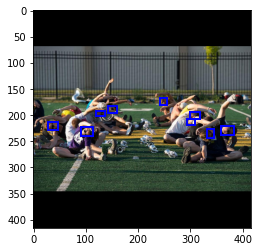

In [8]:
"""
Creates a Pytorch dataset to load the WIDER face dataset
"""

import numpy as np
import os
import pandas as pd
import torch
import albumentations


from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader



ImageFile.LOAD_TRUNCATED_IMAGES = True

def clamp(n, minn, maxn):
    return max(min(maxn, n), minn)


"""
This function returns a dictionary containing all training samples, for each sample containing the image location ("file_name") and defention of the bounding boxes ("bounding_boxes")
returns: the above discribed dict
"""
def read_data_index(index_path):

  training_set = []

  f = open(index_path, "r")

  while True:
    file_name = f.readline().strip()

    if not file_name: break

    boxes = []
    box_count = int(f.readline())
    if box_count >= 1:
      for i in range(box_count):
        box = f.readline().strip().split(' ')
        box = tuple([int(x) for x in box])
        boxes.append(box)
    else:
        next(f)

    
    instance = {
        "file_name": file_name,
        "bounding_boxes": boxes
        }

    training_set.append(instance)

  return training_set



class WIDER_Dataset(Dataset):
    def __init__(
        self,
        index_path,
        image_store_path,
        transform=None,
        max_size=None,
        anchors=CONFIG.ANCHORS,
        image_size=CONFIG.IMAGE_SIZE,
        S=CONFIG.S
    ):
        self.index_path = index_path
        self.image_store_path = image_store_path
        self.data_index = read_data_index(index_path)
        self.max_size = max_size
        self.transform = transform
        self.S = S
        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])  # for all 3 scales
        self.num_anchors = self.anchors.shape[0]
        self.num_anchors_per_scale = self.num_anchors // 3
        self.ignore_iou_thresh = 0.5
        self.DEFAULT_FACE_CLASS = 1

    def __len__(self):
        return (len(self.data_index) if not self.max_size else self.max_size)

    def __getitem__(self, index):

        index_item = self.data_index[index]
        bboxes = index_item.get('bounding_boxes')
        img_path = self.image_store_path + index_item.get('file_name')

        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        bboxes = [[bbox[0],bbox[1],bbox[2],bbox[3]] if bbox[2] > 0 and bbox[3] > 0 else 
                [bbox[0],bbox[1],bbox[2],1] if bbox[2] > 0 else 
                [bbox[0],bbox[1],1,1] for bbox in bboxes]

        # bboxes = [[bbox[0],bbox[1],bbox[2],bbox[3]] for bbox in bboxes if bbox[2] > 0 and bbox[3] > 0]

        if self.transform:
            augmentations = self.transform(image=image, bboxes=bboxes)
            image = augmentations["image"]
            bboxes = augmentations["bboxes"]
        
        image_width = image.shape[1]
        image_height = image.shape[2]

        bboxes = [
                    [max(0,min((bbox[0] + 0.5 * bbox[2] - 1) / image_width,1)), 
                    max(0,min((bbox[1] + 0.5 * bbox[3] - 1) / image_height,1)),
                    min(bbox[2] / image_width,1),
                    min(bbox[3] / image_height,1)] 
                  for bbox in bboxes] #reshape the index from the wider face data to that used by the YOLO v3 tutorial

        targets = bboxes_to_cellvectors(bboxes, self.anchors, self.S, self.ignore_iou_thresh)

        return image, targets#, torch.Tensor(bboxes)
        # return image, bboxes


"""
    This function converts a list of bboxes to the targets for each scale
    input bboxes: a list of bboxes in the form [x, y, width, height]
    returns: a list of size 3 with a target vector for each scale.
"""
def bboxes_to_cellvectors(bboxes, anchors, S, ignore_iou_thresh):
    num_anchors = anchors.shape[0]
    num_anchors_per_scale = num_anchors // 3

    # Below assumes 3 scale predictions (as paper) and same num of anchors per scale
    targets = [torch.zeros((num_anchors // 3, S, S, 5)) for S in S]

    for box in bboxes:

        iou_anchors = UTILS.iou_width_height(torch.tensor(box[2:4]), anchors)  #get a list of the IOU for all anchor boxes for this bounding box
        anchor_indices = iou_anchors.argsort(descending=True, dim=0)  #sort the list of IOU's to get the largest values first

        x, y, width, height = box
        has_anchor = [False] * 3  # each scale should have one anchor (we want to pick one anchor per scale for each bounding box)

        for anchor_idx in anchor_indices: #find an anchor that fits
            scale_idx = anchor_idx // num_anchors_per_scale #determine which scale we're working with
            anchor_on_scale = anchor_idx % num_anchors_per_scale #determines the anchor number on that scale
            s = S[scale_idx] #get the grid size
            i, j = int(s * y), int(s * x)  #determine the cell within the grid cell

            anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 4] #check the objectness value for this anchor to see if its already taken by by some other bbox

            if not anchor_taken and not has_anchor[scale_idx]:

                targets[scale_idx][anchor_on_scale, i, j, 4] = 1  #set objectness prediction target to 1 (as there is an object here)
                x_cell, y_cell = s * x - j, s * y - i  #  determine the x and y coordinates relative to the cell, both between [0,1]
                width_cell, height_cell = (
                    width * s,
                    height * s,
                )  #  determine the width and height of the box relative to the cell, can be greater than 1 since it's relative to cell

                #TODO: width and height should be relative to the anchor!

                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )
                targets[scale_idx][anchor_on_scale, i, j, 0:4] = box_coordinates 

                has_anchor[scale_idx] = True  #notify that the bbox has an anchor for this scale

            elif not anchor_taken and iou_anchors[anchor_idx] > ignore_iou_thresh: #if there is already an anchor for this bbox (so with a better iou)
                targets[scale_idx][anchor_on_scale, i, j, 4] = -1  # set objectness of this anchor to -1 to signal to ignore prediction


    return targets


"""
    This function converts the cellvector of one scale back to a list of bounding boxes
    input cellvectors: cellvector of one scale (anchors per scale, S, S, 6))
    input anchors: a list of anchors for this scale only
    returns: a list of bounding boxes formatted as (x, y, w, h, obj_score)
"""
def cellvector_to_bboxes(cellvectors, anchors):
    S = cellvectors.shape[2]     # get S from the size of the cellvector

    # the following code adds the index of the cell, both i and j, to the x and y positioin of the box relative to the cell. This results in the x and y relative to the image after dividing by the size of the grid
    cell_indices_x = (
          torch.arange(S)
          .repeat(3, S, 1)
      )

    cell_indices_y = cell_indices_x.permute(0, 2, 1)

    scale = 1/S
    x = scale * (cellvectors[..., 0] + cell_indices_x)  # x = (cx + i) / grid_scale
    y = scale * (cellvectors[..., 1] + cell_indices_y)  # y = (cy + j) / grid_scale
    w = scale * cellvectors[...,2]
    h = scale * cellvectors[...,3]
    obj_pred = cellvectors[...,4]

    bboxes = torch.stack((x, y, w, h, obj_pred), dim=-1).reshape(len(anchors) * S * S, 5)

    return bboxes.tolist()

def cellvectors_to_bboxes(cellvectors, anchors):
    assert len(cellvectors) == len(anchors)

    batch_size = cellvectors[0].shape[0]

    bboxes = []
    for i in range(batch_size):
        bboxes_batch = []
        for scale_idx, cellvector in enumerate(cellvectors):
            bboxes_batch.extend(cellvector_to_bboxes(cellvector[i], anchors[scale_idx]))
        bboxes.append(bboxes_batch)

    return bboxes
 

def test():
    anchors = CONFIG.ANCHORS
 
    transform = CONFIG.test_transforms
 
    dataset = WIDER_Dataset(
          CONFIG.INDEX_PATH_TRAIN, 
          CONFIG.IMAGE_STORE_PATH_TRAIN, 
          transform=transform
      )

    S = [13, 26, 52]
    scaled_anchors = torch.tensor(anchors) / (
        1 / torch.tensor(S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    )
    loader = DataLoader(dataset=dataset, batch_size=4, shuffle=False)
    for x, y in loader:
        print(np.shape(y[0]))
        bboxes_batch = cellvectors_to_bboxes(y, anchors)
        bboxes = UTILS.non_max_suppression(bboxes_batch[3], iou_threshold=1, threshold=0.7, box_format="midpoint")

        UTILS.plot_image(x[3].permute(1, 2, 0).to("cpu"), bboxes)

        break
 
test()

# Loss function

In [9]:
"""
Implementation of Yolo Loss Function similar to the one in Yolov3 paper,
the difference from what I can tell is I use CrossEntropy for the classes
instead of BinaryCrossEntropy.
"""
import random
import torch
import torch.nn as nn

class YoloLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()

        # Constants signifying how much to pay for each respective part of the loss
        self.lambda_class = 1
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 10

    def forward(self, predictions, target, anchors):
        # FORMAT: (x, y, w, h, obj)
        # print(np.shape(predictions))
        # print(np.shape(target))

        box_preds = predictions[...,0:4]
        obj_preds = predictions[...,4]

        box_target = target[...,0:4]
        obj_target = target[...,4]

        # Check where obj and noobj (we ignore if target == -1)
        obj = target[..., 4] == 1  # in paper this is Iobj_i
        noobj = target[..., 4] == 0  # in paper this is Inoobj_i
        # print(np.shape(obj))

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        no_object_loss = self.bce(
            (obj_preds[noobj]), (obj_target[noobj]),
        )

        # no_object_loss = self.bce(
        #     (predictions[..., 5][noobj]), (target[..., 5][noobj]),
        # )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        ious = UTILS.intersection_over_union(box_preds[obj], box_target[obj]).detach()
        object_loss = self.mse(obj_preds[obj], ious * obj_target[obj])

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #
        # target[..., 3:5] = torch.log(
        #     (1e-16 + target[..., 3:5] / anchors)
        # )  # width, height coordinates 
        # above still necessary? 
        box_loss = self.mse(box_preds[obj], box_target[obj])

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        # print("__________________________________")
        # print(self.lambda_box * box_loss)
        # print(self.lambda_obj * object_loss)
        # print(self.lambda_noobj * no_object_loss)
        # print("\n")

        return (
            self.lambda_box * box_loss
            + self.lambda_obj * object_loss
            + self.lambda_noobj * no_object_loss
        )

# train method

In [10]:
model = YOLOv3().to(CONFIG.DEVICE)

In [11]:
"""
Main file for training Yolo model on WIDER Face
"""

import torch
import torch.optim as optim

from tqdm import tqdm

import warnings
from IPython.display import clear_output
from sklearn.model_selection import KFold

warnings.filterwarnings("ignore")

torch.backends.cudnn.benchmark = True


def train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors):
    loop = tqdm(train_loader, leave=True)
    losses = []
    for batch_idx, (x, y) in enumerate(loop):
        x = x.to(CONFIG.DEVICE)
        y0, y1, y2 = (
            y[0].to(CONFIG.DEVICE),
            y[1].to(CONFIG.DEVICE),
            y[2].to(CONFIG.DEVICE),
        )

        with torch.cuda.amp.autocast():
            out = model(x)
            loss = (
                loss_fn(out[0], y0, scaled_anchors[0])
                + loss_fn(out[1], y1, scaled_anchors[1])
                + loss_fn(out[2], y2, scaled_anchors[2])
            )

        losses.append(loss.item())
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update progress bar
        mean_loss = sum(losses) / len(losses)
        loop.set_postfix(loss=mean_loss)


def evaluate_model(test_loader, model):
    model.eval()

    UTILS.plot_examples(test_loader, model)

    pred_boxes, true_boxes = UTILS.get_evaluation_bboxes2(
                    test_loader,
                    model
                )
    
    model.train()
    
    mAP = UTILS.mean_average_precision(pred_boxes, true_boxes)

    
    # class_accuracy, no_obj_accuracy, obj_accuracy = UTILS.check_class_accuracy(model, test_loader, threshold=CONFIG.CONF_THRESHOLD)

    return mAP#, class_accuracy, no_obj_accuracy, obj_accuracy

# based on https://www.machinecurve.com/index.php/2021/02/03/how-to-use-k-fold-cross-validation-with-pytorch/
def kfold_train(model, dataset, n_fold = 5):
    mAPs = []
    optimizer = optim.Adam(
        model.parameters(), lr=CONFIG.LEARNING_RATE, weight_decay=CONFIG.WEIGHT_DECAY
    )
    loss_fn = YoloLoss()
    scaler = torch.cuda.amp.GradScaler()
    if CONFIG.LOAD_MODEL:
        UTILS.load_checkpoint(
            CONFIG.CHECKPOINT_FILE, model, optimizer, CONFIG.LEARNING_RATE
        )

    scaled_anchors = (
        torch.tensor(CONFIG.ANCHORS)
        * torch.tensor(CONFIG.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    ).to(CONFIG.DEVICE)

    kfold = KFold(n_splits=n_fold,shuffle=True)

    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        print("Fold nr: {}".format(fold))
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        test_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

        trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=CONFIG.BATCH_SIZE,
                      num_workers=CONFIG.NUM_WORKERS,
                      pin_memory=CONFIG.PIN_MEMORY, 
                      shuffle=True,
                      drop_last=False,
                      sampler=train_subsampler
        )
        testloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=CONFIG.BATCH_SIZE,
                      num_workers=CONFIG.NUM_WORKERS,
                      pin_memory=CONFIG.PIN_MEMORY, 
                      shuffle=True,
                      drop_last=False,
                      sampler=test_subsampler
        )


        model.apply(reset_weights)

        for epoch in range(500): #range(CONFIG.NUM_EPOCHS):
            if epoch > 0 and epoch % 10 == 0:
                clear_output(wait=True)
                print("Epoch {}".format(epoch))
            train_fn(trainloader, model, optimizer, loss_fn, scaler, scaled_anchors)

            if CONFIG.SAVE_MODEL:
                UTILS.save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

            # every so many epochs, evaluate the model
            # if epoch > 0 and epoch % 10 == 0:
            #     mAP = evaluate_model(testloader, model)
            #     print("mAP = {}".format(mAP))
                
            #     mAPs.append(mAP.tolist())
            #     print(mAPs)

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

def main(model):
    mAPs = []
    optimizer = optim.Adam(
        model.parameters(), lr=CONFIG.LEARNING_RATE, weight_decay=CONFIG.WEIGHT_DECAY
    )
    loss_fn = YoloLoss()
    scaler = torch.cuda.amp.GradScaler()

    train_loader, test_loader, train_loader_evaluation = UTILS.get_loaders()

    if CONFIG.LOAD_MODEL:
        UTILS.load_checkpoint(
            CONFIG.CHECKPOINT_FILE, model, optimizer, CONFIG.LEARNING_RATE
        )

    scaled_anchors = (
        torch.tensor(CONFIG.ANCHORS)
        * torch.tensor(CONFIG.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
    ).to(CONFIG.DEVICE)

    for epoch in range(1000): #range(CONFIG.NUM_EPOCHS):
        if epoch > 0 and epoch % 10 == 0:
            clear_output(wait=True)
            print("Epoch {}".format(epoch))
        train_fn(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors)

        if CONFIG.SAVE_MODEL:
           UTILS.save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

        # every so many epochs, evaluate the model
        if epoch > 0 and epoch % 10 == 0:

            mAP = evaluate_model(train_loader_evaluation, model)
            print("mAP = {}".format(mAP))
            
            mAPs.append(mAP.tolist())
            # print(mAPs)
            # print(f"Class accuracy is: {class_accuracy:2f}%")
            # print(f"No obj accuracy is: {no_obj_accuracy:2f}%")
            # print(f"Obj accuracy is: {obj_accuracy:2f}%")
    
    x = np.linspace(10,10+len(mAPs)*10,len(mAPs))
    plt.plot(x,mAPs)
            
main(model)

  0%|          | 0/1074 [00:06<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 2.66 GiB already allocated; 0 bytes free; 2.67 GiB reserved in total by PyTorch)

In [ ]:
optimizer = optim.Adam(
    model.parameters(), lr=CONFIG.LEARNING_RATE, weight_decay=CONFIG.WEIGHT_DECAY
)
UTILS.save_checkpoint(model, optimizer, filename=CONFIG.CHECKPOINT_FILE)

In [ ]:
train_loader, test_loader, train_loader_evaluation = UTILS.get_loaders()
UTILS.plot_examples(train_loader_evaluation, model)